In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import json
from skimage.exposure import match_histograms
from google.colab.patches import cv2_imshow
import sys
from skimage.metrics import structural_similarity
import imutils
import os
from tqdm import tqdm
import pickle

In [3]:
!pip install -U -q PyDrive

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
file_id = '19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('dataset.zip')

## Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
! unzip "/content/dataset.zip" -d Dataset
! unzip "/content/patterns.zip" -d Patterns

Archive:  /content/dataset.zip
 extracting: Dataset/1644359422.816138.jpg  
  inflating: Dataset/1644359422.816138.json  
 extracting: Dataset/1644360063.82364.jpg  
  inflating: Dataset/1644360063.82364.json  
 extracting: Dataset/1644362482.7094185.jpg  
  inflating: Dataset/1644362482.7094185.json  
 extracting: Dataset/1644368971.6154966.jpg  
  inflating: Dataset/1644368971.6154966.json  
 extracting: Dataset/1644369207.922902.jpg  
  inflating: Dataset/1644369207.922902.json  
 extracting: Dataset/1644369658.7214494.jpg  
  inflating: Dataset/1644369658.7214494.json  
 extracting: Dataset/1644369774.9055796.jpg  
  inflating: Dataset/1644369774.9055796.json  
 extracting: Dataset/1644369801.9909956.jpg  
  inflating: Dataset/1644369801.9909956.json  
 extracting: Dataset/1644369842.0238864.jpg  
  inflating: Dataset/1644369842.0238864.json  
 extracting: Dataset/1644369905.2248352.jpg  
  inflating: Dataset/1644369905.2248352.json  
 extracting: Dataset/1644369972.1056488.jpg  
 

In [8]:
img_name = "/content/Dataset/1644359422.816138.jpg"
json_name = img_name[:-3] + "json"

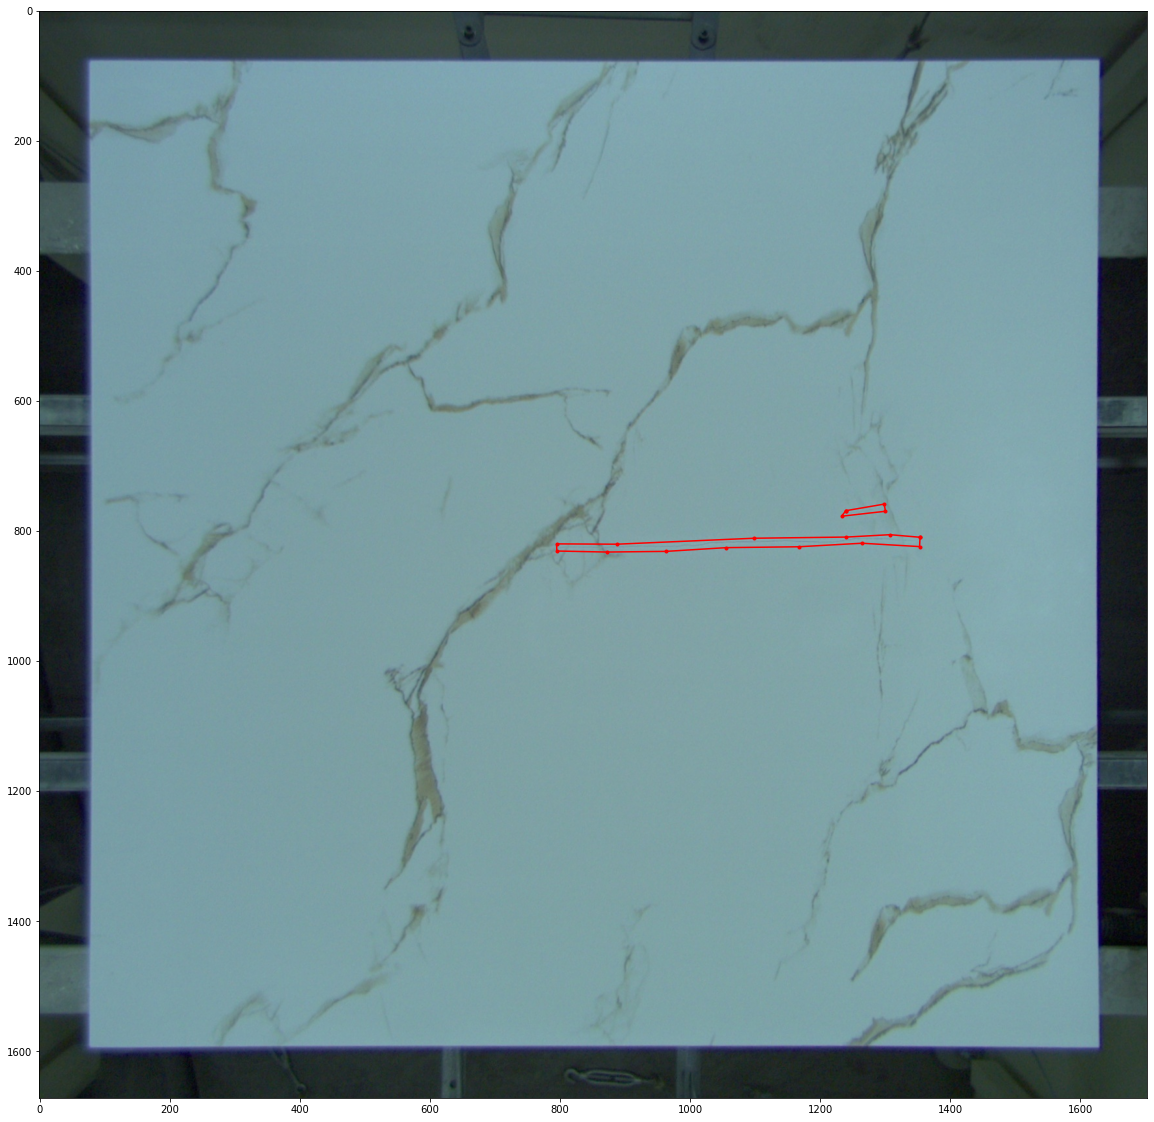

In [9]:
img = cv2.imread(img_name)

f = open(json_name, encoding="utf8")
data = json.load(f)
f.close()

plt.figure(figsize=(20, 20))
plt.imshow(img[..., ::-1])

for shape in data["shapes"]:
  points = np.array(shape['points'])
  ind = list(np.arange(points.shape[0])) + [0]
  plt.plot(points[ind, 0], points[ind, 1], 'r.-')
  # plt.plot(points[-1:-3:-1, 0], points[-1:-3:-1, 1], 'r')

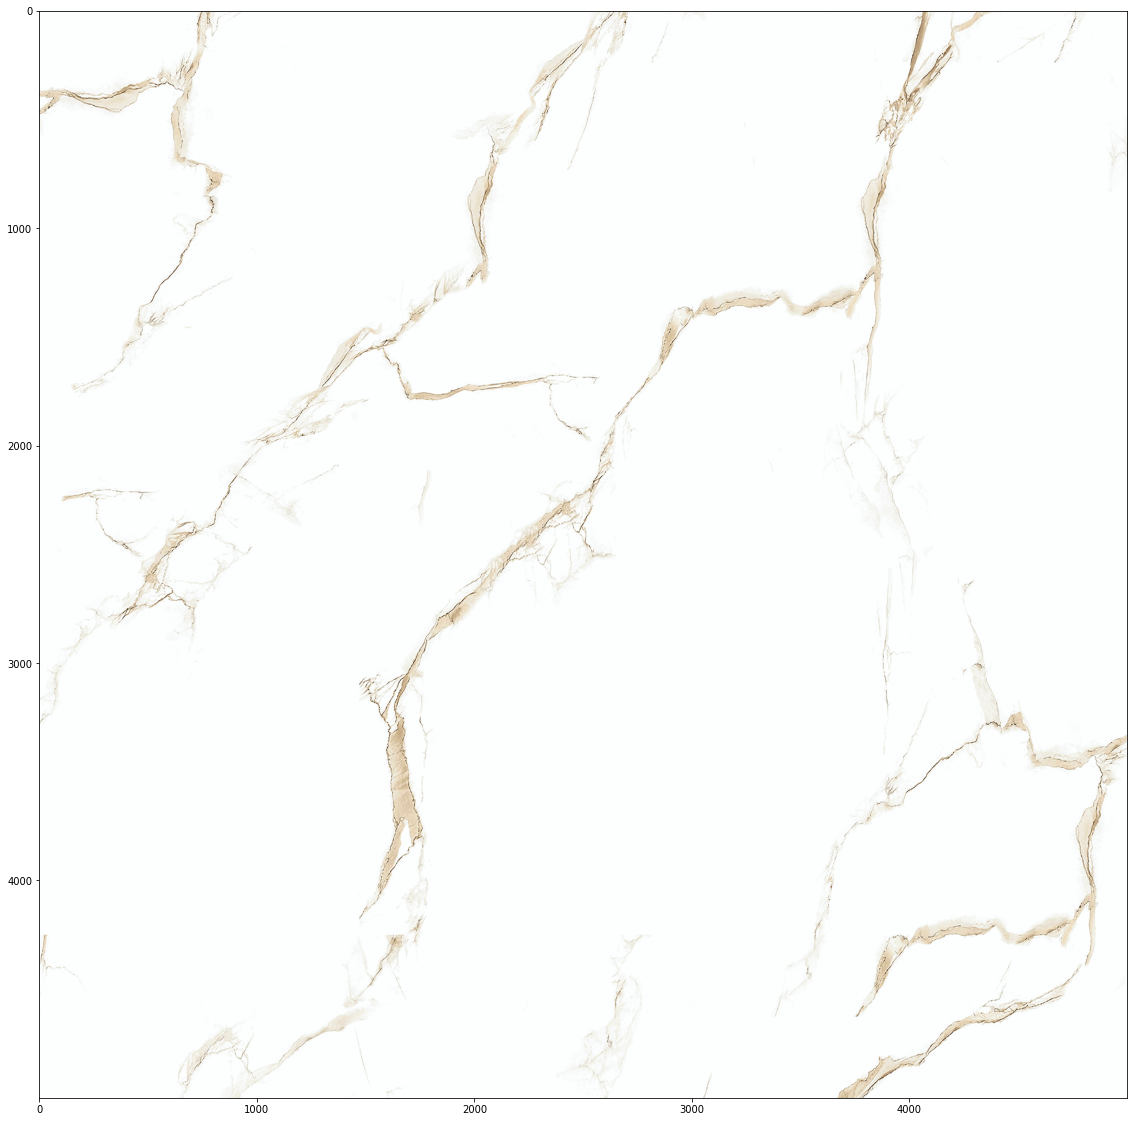

In [10]:
pattern = cv2.imread('/content/Patterns/' + data['pattern'])

plt.figure(figsize=(20, 20))
plt.imshow(pattern[..., ::-1])

## Load Dataset

In [11]:
images = []
labels = []
names=[]

for file in os.listdir("/content/Dataset/"):
  if file.endswith(".jpg"):
    images.append(cv2.imread(os.path.join("/content/Dataset/",file))[74:1590,74:1590])
    
    img_name = "/content/Dataset/"+file
    names.append(img_name)

  elif file.endswith(".png"):
    images.append(cv2.imread(os.path.join("/content/Dataset/",file))[74:1590,74:1590])

    img_name = "/content/Dataset/"+file
    names.append(img_name)

  elif file.endswith(".json"):
    labels.append(json.load(open(os.path.join("/content/Dataset/",file))))

In [12]:
pth= "/content/Patterns/"
pattern_path=[]
for file in os.listdir(pth):
  if file.endswith(".tif"):
    pattern_path.append(os.path.join(pth,file))
patterns=[]
for im in pattern_path:
  patterns.append(cv2.imread(im))


## Create Labels

In [13]:
def create_label(img,data):  
  image = img.copy()
  cracks=[]

  for shape in data["shapes"]:
    cracks.append(np.array(shape['points']))

  label = np.zeros((image.shape[0],image.shape[1]))

  new_cracks=[]

  for i in range(len(cracks)):
    points=[]
    for j in range(len(cracks[i])):
      points.append([int(cracks[i][j][0]),int(cracks[i][j][1])])
    new_cracks.append(points)  

  for i in range(len(new_cracks)):
    p=np.array(new_cracks[i])
    cv2.fillPoly(label,pts=[p],color=(255,0,0))

  return label

## Rotation

In [14]:
#Histogram Matching of all dataset
final_patterns={}

new_patterns = [None] * len(pattern_path)
pattern_visited = [False] * len(pattern_path)

for i in range(len(images)):
  reference = images[i]  
  pattern_name = labels[i]['pattern']
  pattern_img = None
  for j in range(len(pattern_path)):
    if (not pattern_visited[j]) and pattern_path[j].split('/')[-1] == pattern_name:
      pattern_img = patterns[j]
      pattern_visited[j] = True
      source = pattern_img
      matched = match_histograms(source, reference, multichannel=True)
      new_patterns[j] = matched
      final_patterns[pattern_name]=new_patterns[j]
      break

In [15]:
new_patterns=[]

In [16]:
def rotation_degree(good_points, p1, p2):

  degrees = {'0' : 0, '90': 0, '180' : 0, '270' : 0}

  for point in good_points:
    indx1 = point.queryIdx
    indx2 = point.trainIdx

    x1, y1 = p1[indx1].pt
    x2, y2 = p2[indx2].pt

    if x1 < 800 and y1 < 800:
      if x2 < 2500 and y2 < 2500:
        degrees['0'] += 1
      elif x2 < 2500 and y2 > 2500:
        degrees['90'] += 1
      elif x2 > 2500 and y2 > 2500:
        degrees['180'] += 1
      elif x2 > 2500 and y2 < 2500:
        degrees['270'] += 1

    elif x1 < 800 and y1 > 800:
      if x2 < 2500 and y2 < 2500:
        degrees['270'] += 1
      elif x2 < 2500 and y2 > 2500:
        degrees['0'] += 1
      elif x2 > 2500 and y2 > 2500:
        degrees['90'] += 1
      elif x2 > 2500 and y2 < 2500:
        degrees['180'] += 1

    elif x1 > 800 and y1 > 800:
      if x2 < 2500 and y2 < 2500:
        degrees['180'] += 1
      elif x2 < 2500 and y2 > 2500:
        degrees['270'] += 1
      elif x2 > 2500 and y2 > 2500:
        degrees['0'] += 1
      elif x2 > 2500 and y2 < 2500:
        degrees['90'] += 1

    elif x1 < 800 and y1 > 800:
      if x2 < 2500 and y2 < 2500:
        degrees['90'] += 1
      elif x2 < 2500 and y2 > 2500:
        degrees['180'] += 1
      elif x2 > 2500 and y2 > 2500:
        degrees['270'] += 1
      elif x2 > 2500 and y2 < 2500:
        degrees['0'] += 1

  result = None

  m = 0
  
  for k in degrees.keys():
    if degrees[k] > m:
      m = degrees[k]
      result = k
  return result

In [17]:
def find_keypoints(img1, img2):
  original = img1
  reference = img2 
  height, width, c = original.shape

  sift = cv2.xfeatures2d.SIFT_create()
  key_points1, desc1 = sift.detectAndCompute(original, None)
  key_points2, desc2 = sift.detectAndCompute(reference, None)

  index_params = dict(algorithm=0, trees=5)
  search_params = dict()
  flann = cv2.FlannBasedMatcher(index_params, search_params)

  matches = flann.knnMatch(desc1, desc2, k=2)

  good_points = []
  ratio = 0.8
  for m, n in matches:
      if m.distance < ratio*n.distance:
          good_points.append(m)

  degree = rotation_degree(good_points, key_points1, key_points2)
  return degree

In [18]:
def rotate_image(img, degree):
  if degree == '90':
    return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

  elif degree == '270':
    return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

  elif degree == '180':
    return cv2.rotate(img, cv2.ROTATE_180)

  else:
    return img


In [19]:
def resize_pattern(rotated_pattern, scale = 1516/5000):
  resized_pattern = cv2.resize(rotated_pattern, dsize=(0,0), fx=scale, fy=scale)
  return resized_pattern

## Thresholding

In [20]:
def thresholding(img, resized_pattern):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
  th2 = cv2.adaptiveThreshold(img,100,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,21,5)

  img = resized_pattern
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )

  th1 = cv2.adaptiveThreshold(img,100,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,21,5)

  subtracted = cv2.subtract(th1, th2)
  return subtracted

## PreProcess



In [21]:
all_data = []
for i in range(len(names)):
  img_name = names[i]
  json_name = img_name[:-3] + "json"

  f = open(json_name, encoding="utf8")
  data = json.load(f)
  f.close()
  all_data.append(data)

In [22]:
!mkdir Images
!mkdir Labels

In [23]:
def preprocess_image(image, pattern):
  degree = find_keypoints(image, pattern)
  rotated_pattern = rotate_image(pattern, degree)
  resized_pattern = resize_pattern(rotated_pattern, scale = 1516/5000)
  image_result = thresholding(image, resized_pattern)
  return image_result

In [33]:
def preprocess_data(images,final_patterns):

  for start_idx in tqdm(range(0, len(images), 10)):
    images_batch = images[start_idx: start_idx + 10]
    indx = start_idx
    
    for i in range(len(images_batch)):
    
      new_indx = indx + i

      image = images_batch[i]
      img_name = names[new_indx]
      
      pattern = final_patterns[all_data[new_indx]['pattern']]

      img_result = preprocess_image(image,pattern)
      img_name_new = img_name.replace("/content/Dataset/","")
     
      # with open('/content/Images/'+img_name_new[:-3] +'pkl', 'wb') as f:
      #   pickle.dump(img_result, f)

      label = create_label(img_result, all_data[new_indx])
      with open('/content/Labels/'+img_name_new[:-3] +'pkl', 'wb') as f:
        pickle.dump(label, f)   

    images_batch=[] 
    print("finished")


In [34]:
preprocess_data(images,final_patterns)

  3%|▎         | 1/31 [01:39<49:50, 99.69s/it]

finished


  6%|▋         | 2/31 [03:12<46:09, 95.52s/it]

finished


 10%|▉         | 3/31 [04:46<44:21, 95.05s/it]

finished


 13%|█▎        | 4/31 [06:16<41:44, 92.76s/it]

finished


 16%|█▌        | 5/31 [07:47<39:58, 92.25s/it]

finished


 19%|█▉        | 6/31 [09:23<38:56, 93.48s/it]

finished


 23%|██▎       | 7/31 [10:54<37:06, 92.77s/it]

finished


 26%|██▌       | 8/31 [12:29<35:47, 93.38s/it]

finished


 29%|██▉       | 9/31 [13:58<33:44, 92.04s/it]

finished


 32%|███▏      | 10/31 [15:29<32:05, 91.69s/it]

finished


 35%|███▌      | 11/31 [17:03<30:47, 92.39s/it]

finished


 39%|███▊      | 12/31 [18:31<28:51, 91.12s/it]

finished


 42%|████▏     | 13/31 [20:05<27:35, 91.95s/it]

finished


 45%|████▌     | 14/31 [21:35<25:53, 91.36s/it]

finished


 48%|████▊     | 15/31 [23:06<24:19, 91.20s/it]

finished


 52%|█████▏    | 16/31 [24:43<23:17, 93.16s/it]

finished


 55%|█████▍    | 17/31 [26:20<21:58, 94.19s/it]

finished


 58%|█████▊    | 18/31 [27:56<20:33, 94.88s/it]

finished


 61%|██████▏   | 19/31 [29:29<18:48, 94.07s/it]

finished


 65%|██████▍   | 20/31 [31:04<17:17, 94.34s/it]

finished


 68%|██████▊   | 21/31 [32:39<15:46, 94.63s/it]

finished


 71%|███████   | 22/31 [34:15<14:14, 94.97s/it]

finished


 74%|███████▍  | 23/31 [35:51<12:43, 95.47s/it]

finished


 77%|███████▋  | 24/31 [37:24<11:02, 94.70s/it]

finished


 81%|████████  | 25/31 [39:02<09:34, 95.79s/it]

finished


 84%|████████▍ | 26/31 [40:37<07:57, 95.50s/it]

finished


 87%|████████▋ | 27/31 [42:09<06:17, 94.45s/it]

finished


 90%|█████████ | 28/31 [43:47<04:46, 95.51s/it]

finished


 94%|█████████▎| 29/31 [45:20<03:09, 94.74s/it]

finished


 97%|█████████▋| 30/31 [47:00<01:36, 96.16s/it]

finished


100%|██████████| 31/31 [47:09<00:00, 91.28s/it]

finished


In [ ]:
%cp /content/Images /content/drive/MyDrive/Dataset -r

In [ ]:
%cp /content/Labels /content/drive/MyDrive/Dataset -r

In [ ]:
%cp /content/Patterns /content/drive/MyDrive/Dataset -r

In [37]:
!rm -rf /content/drive/MyDrive/Dataset/Label/*

In [38]:
!cp -r /content/Labels/* /content/drive/MyDrive/Dataset/Label